# Analytical Feature Map

Aim: to reduce the full dataset of GPS traces into a regular grid of aggregated analytical features: an Analytical Feature Map. 

In tracklib, the class *Raster* can manage these set of *AFMap*:
<br/>
<div class="alert alert-block alert-info" style="padding:1em">
    
```python
  raster = summarize(collection, ...)
  countTrackMap = raster.getAFMap(...)
```

</div>

## As usual, let's start by defining our environment

The first task is only useful for the online notebook and import the local tracklib code source. It's not necessary if tracklib is installed from PyPI.

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Let's load the necessary libraries

In [2]:
# Matplotlib to create visualizations
import matplotlib.pyplot as plt

# Module to do progress reporting
import progressbar

# Import tracklib library
import tracklib as tkl

## Loading a collection of tracks

In [3]:
tkl.ObsTime.setReadFormat("2D/2M/4Y 2h:2m:2s")
chemin = '/home/md_vandamme/tracklib/trajlib/reseau/data2/'
fmt = tkl.TrackFormat({"ext": 'CSV',
    "id_E": 1,
    "id_N": 0,
    "id_U": 3,
    "id_T": 2,
    "h": 1,
    "separator": ";",
    "srid": "ENU"})
collection = tkl.TrackReader.readFromFile(chemin, fmt)
print ('Number of tracks: ' + str(collection.size()))

Number of tracks: 8654


## Zoom in on a small area around a lake

We extracte tracks abiding by geometrical shape (a Rectangle) constraint are cut and returned in the next stage below:

Number of tracks near the lake: 8654


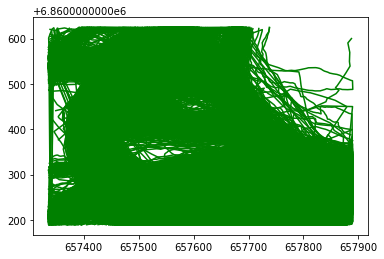

In [4]:
xMin = 657336
yMin = 6860189
xMax = 657890
yMax = 6860625

ll = tkl.ENUCoords(xMin, yMin)
ur = tkl.ENUCoords(xMax, yMax)
bbox = tkl.Rectangle(ll, ur)

constraintBBox = tkl.Constraint(shape = bbox, mode = tkl.MODE_INSIDE, type=tkl.TYPE_CUT_AND_SELECT)
lakeCollection = constraintBBox.select(collection)
print ('Number of tracks near the lake: ' + str(lakeCollection.size()))
lakeCollection.plot('g-')

## Crowd density Map

We need to define first 2 things: the analytical feature to be aggregated and the aggregation operator. Several AFs can be aggregated with different aggregation operator simultaneously, but in this example, we calculate only one: the frequency of trajectories. To do this, we count the number of tracks crossing each, so the operator is the count operator **co_count_distinct** and the AF is the trace identifier **uid**.


In [5]:
af_algos = ['uid']
cell_operators = [tkl.co_count_distinct]

To ensure that tracks are taken into account in the counting, we make a spatial resample with a point every meter.

In [6]:
cpt = 1
for trace in lakeCollection:
    trace.uid = cpt
    trace.resample(1, mode=1)
    cpt += 1

### Create a Raster, allocate segments of GPS trajectories on the regular grid and compute aggregated analytical feature

A 2 meter-resolution base grid is made, with no margin on the bounding box of tracks collection. In our case, the number of tracks per cell is counted.

In [7]:
bbox = lakeCollection.bbox()
marge = 0
resolution = (2, 2)

raster = tkl.summarize(lakeCollection, af_algos, cell_operators, resolution, marge)
print ('Raster created.')

Raster created.


### Get the crowd density AFMap

In [8]:
freqMap = raster.getAFMap(tkl.AFMap.getMeasureName('uid', tkl.co_count_distinct))

### Display the grid of frequency of trajectories

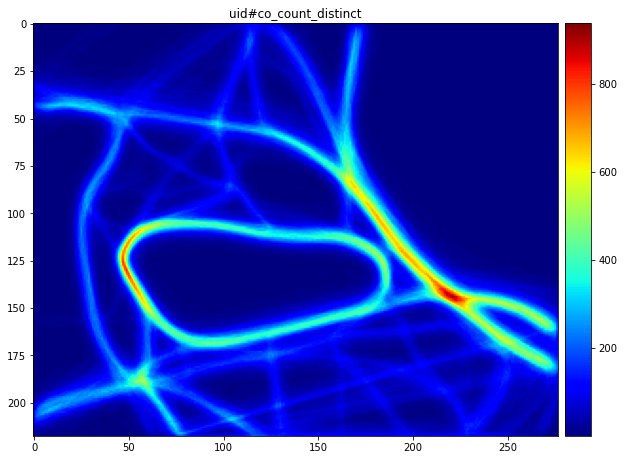

In [9]:
plt.figure(figsize=(10, 10))
cmap = plt.cm.get_cmap('jet').copy()
cmap.set_bad(color = cmap(0.0))
freqMap.plotAsImage(cmap=cmap, append=True)
plt.show()

## Write frequency of trajectories grid to Ascii Raster file

In [10]:
tkl.RasterWriter.writeMapToAscFile('/home/md_vandamme/zone_lac_2m.asc', freqMap)
print ('Grid written in file.')

Grid written in file.
